# Titanic survival - feature selection 2 (model forward selection)

In [2]:
# Hide warnings (to keep notebook tidy; do not usually do this)
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Load modules
import numpy as np
import pandas as pd
# Import machine learning methods
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [4]:
data = pd.read_csv('C:/t_data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

In [5]:
# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

In [6]:
#Divide into X (features) and y (labels)
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

## Forward feature selection

In [7]:
def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

In [8]:
# Create list to store accuracies and chosen features
roc_auc_by_feature_number = []
chosen_features = []

# Initialise chosen features list and run tracker
available_features = list(X)
run = 0
number_of_features = len(list(X))

# Loop through feature list to select next feature
while len(available_features)> 0:

    # Track and pront progress
    run += 1
    print ('Feature run {} of {}'.format(run, number_of_features))
    
    # Convert DataFrames to NumPy arrays
    y_np = y.values
    
    # Reset best feature and accuracy
    best_result = 0
    best_feature = ''

    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid original being changed
        features_to_use = chosen_features.copy()
        # Create a list of features from features already chosen + 1 new feature
        features_to_use.append(feature)
        # Get data for features, and convert to NumPy array
        X_np = X[features_to_use].values
        
        # Set up lists to hold results for each selected features
        test_auc_results = []
    
        # Set up k-fold training/test splits
        number_of_splits = 5
        skf = StratifiedKFold(n_splits = number_of_splits)
        skf.get_n_splits(X_np, y)
    
        # Loop through the k-fold splits
        for train_index, test_index in skf.split(X_np, y_np):
            
            # Get X and Y train/test
            X_train, X_test = X_np[train_index], X_np[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
            # Get X and Y train/test
            X_train_std, X_test_std = standardise_data(X_train, X_test)
    
            # Set up and fit model
            model = LogisticRegression(solver='lbfgs')
            model.fit(X_train_std,y_train)
    
            # Predict test set labels
            y_pred_test = model.predict(X_test_std)
            
            # Calculate accuracy of test sets
            accuracy_test = np.mean(y_pred_test == y_test)
          
            # Get ROC AUC
            probabilities = model.predict_proba(X_test_std)
            probabilities = probabilities[:, 1] # Probability of 'survived'
            fpr, tpr, thresholds = roc_curve(y_test, probabilities)
            roc_auc = auc(fpr, tpr)
            test_auc_results.append(roc_auc)
        
        # Get average result from all k-fold splits
        feature_auc = np.mean(test_auc_results)
    
        # Update chosen feature and result if this feature is a new best
        if feature_auc > best_result:
            best_result = feature_auc
            best_feature = feature
    
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    roc_auc_by_feature_number.append(best_result)
    chosen_features.append(best_feature)
    available_features.remove(best_feature)

# Put results in DataFrame
results = pd.DataFrame()
results['feature to add'] = chosen_features
results['ROC AUC'] = roc_auc_by_feature_number

Feature run 1 of 24
Feature run 2 of 24
Feature run 3 of 24
Feature run 4 of 24
Feature run 5 of 24
Feature run 6 of 24
Feature run 7 of 24
Feature run 8 of 24
Feature run 9 of 24
Feature run 10 of 24
Feature run 11 of 24
Feature run 12 of 24
Feature run 13 of 24
Feature run 14 of 24
Feature run 15 of 24
Feature run 16 of 24
Feature run 17 of 24
Feature run 18 of 24
Feature run 19 of 24
Feature run 20 of 24
Feature run 21 of 24
Feature run 22 of 24
Feature run 23 of 24
Feature run 24 of 24


In [9]:
results

,feature to add,ROC AUC
0,male,0.766818
1,Pclass,0.833003
2,Age,0.843038
3,SibSp,0.848621
4,Embarked_S,0.853128
5,CabinLetter_E,0.856015
6,CabinNumberImputed,0.856436
7,CabinLetter_F,0.856244
8,CabinLetter_D,0.856363
9,CabinLetter_T,0.856470


### Plot results

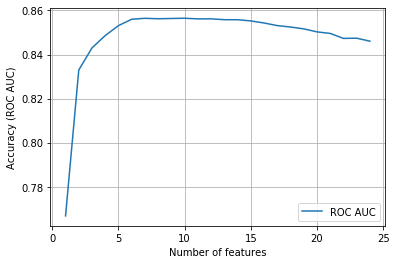

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

chart_x = list(range(1, number_of_features+1))

plt.plot(chart_x, roc_auc_by_feature_number,
        label = 'ROC AUC')

plt.xlabel('Number of features')
plt.ylabel('Accuracy (ROC AUC)')
plt.legend()
plt.grid(True)

plt.show()